# Generación de ruido para simular NeuroStrike


El objetivo de este cuaderno es generar diferentes tipos de ruido para simular el comportamiento de un NeuroStrike en el cerebro.


In [1]:
# Importamos las librerías necesarias
import os
from pathlib import Path
import numpy as np
from typing import *
import matplotlib.pyplot as plt
from LennartToellke_files.plotting_Toellke import *
from scipy import signal
from eeg_attacks import *

# Guardamos la ruta de este script y con ella la de la carpeta donde están los archivos .eeg
notebook_folder: Path = Path(os.getcwd()).resolve()
eeg_folder: Path = notebook_folder / "eeg_files"

In [2]:
# Creamos un diccionario para almacenar los datos de los archivo EEG
eeg_data: Dict[str, np.ndarray] = {}

# Creamos un bucle para recorrer los archivos en la carpeta eeg_files
for file in eeg_folder.iterdir():
    if file.is_file() and file.suffix == ".txt" and "sleep" in file.name:
        data = np.loadtxt(file)
        name = file.stem.replace("input_nonepi_", "")
        eeg_data[name] = data

# Guardamos los nombres de los canales en una lista
channel_names = sorted(eeg_data.keys())

# Definimos la frecuencia de muestreo
sfreq = 1024.0

## Ruido blanco

La primera aproximación es generar ruido blanco en los datos. Para añadir ruido blanco podemos cambiar dos valores: $mu$ (la media del ruido) y $sigma$ (la desviación estándar del ruido).

- $mu = 0$
- $sigma = sd(signal)$ (ruido perceptible a la vista)
- $sigma = sd(signal) \cdot 0.1$ (ruido imperceptible a la vista)

Se va a sumar el valor absoluto del ruido para no generar valores negativos de potencial, los cuales no tienen sentido en el contexto de los archivos EEG.


### Ruido blanco perceptible


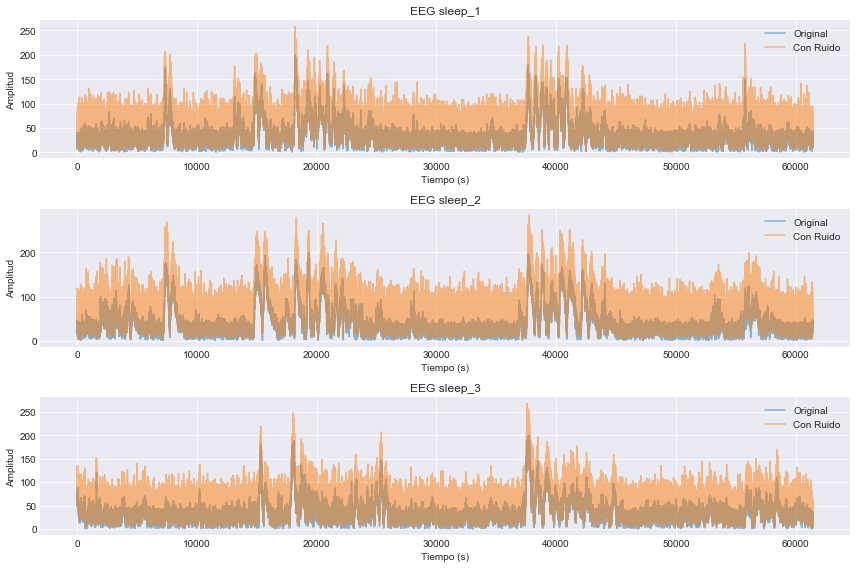

In [3]:
# Añadimos ruido blanco a los datos EEG
eeg_files_noise: Dict[str, np.ndarray] = {}
for key in channel_names:
    noise = white_noise(len(eeg_data[key]), 0, eeg_data[key].std())
    eeg_files_noise[key] = eeg_data[key] + np.abs(noise)

# Guardamos los datos con ruido en archivos .txt
eeg_noise_folder: Path = notebook_folder / \
    "eeg_files_noise" / "eeg_files_noise_1"
# Crea la carpeta si no existe
eeg_noise_folder.mkdir(exist_ok=True, parents=True)
for key in channel_names:
    np.savetxt(eeg_noise_folder /
               f"input_nonepi_{key}.txt", eeg_files_noise[key], fmt="%.6f")

# Finalmente graficamos los datos con ruido sobre los originales
plt.style.use("seaborn-darkgrid")
plt.figure(figsize=(12, 8))
for i, key in enumerate(channel_names):
    plt.subplot(len(channel_names), 1, i + 1)
    plt.plot(eeg_data[key], label="Original", alpha=0.5)
    plt.plot(eeg_files_noise[key], label="Con Ruido", alpha=0.5)
    plt.title(f"EEG {key}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.tight_layout()

### Ruido blanco imperceptible


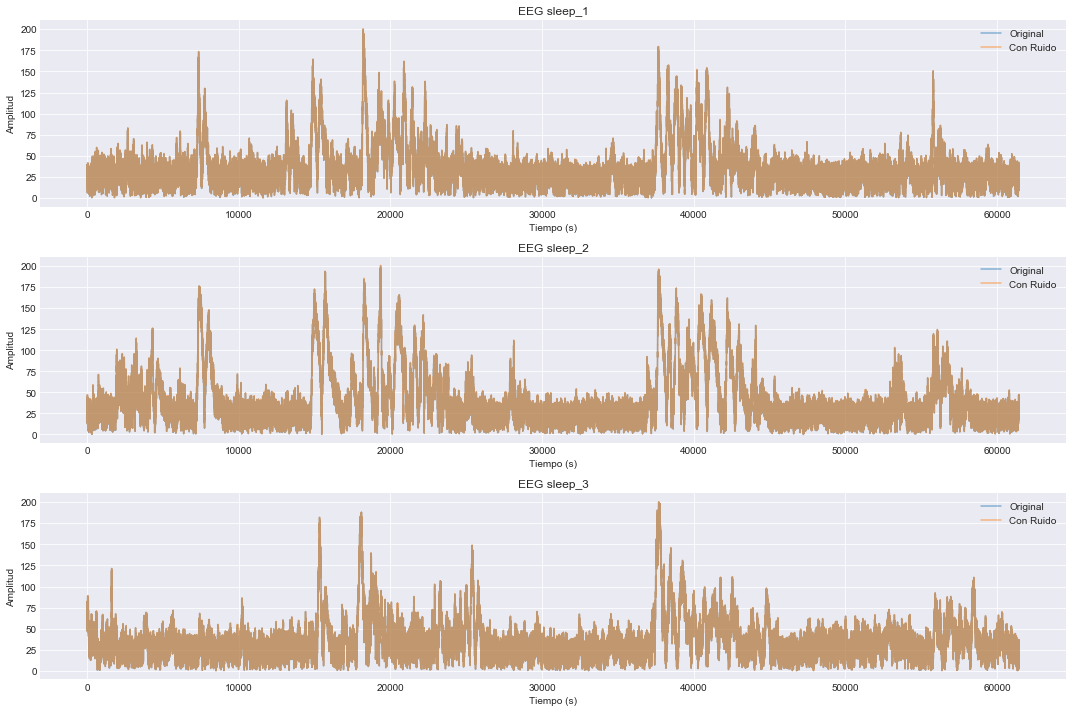

In [4]:
# Añadimos ruido blanco a los datos EEG
eeg_files_noise: Dict[str, np.ndarray] = {}
for key in channel_names:
    noise = white_noise(len(eeg_data[key]), 0, eeg_data[key].std()*.01)
    eeg_files_noise[key] = eeg_data[key] + np.abs(noise)

# Guardamos los datos con ruido en archivos .txt
eeg_noise_folder: Path = notebook_folder / \
    "eeg_files_noise" / "eeg_files_noise_2"
# Crea la carpeta si no existe
eeg_noise_folder.mkdir(exist_ok=True, parents=True)
for key in channel_names:
    np.savetxt(eeg_noise_folder /
               f"input_nonepi_{key}.txt", eeg_files_noise[key], fmt="%.6f")

# Finalmente graficamos los datos con ruido sobre los originales
plt.style.use("seaborn-darkgrid")
plt.figure(figsize=(15, 10))
for i, key in enumerate(channel_names):
    plt.subplot(len(channel_names), 1, i + 1)
    plt.plot(eeg_data[key], label="Original", alpha=0.5)
    plt.plot(eeg_files_noise[key], label="Con Ruido", alpha=0.5)
    plt.title(f"EEG {key}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.tight_layout()

## Pulso gaussiano

En la revisión bibliográfica del TFM de Lennart se menciona que los pulsos de radio frecuencia causan daños químicos y estructurales notables en el cerebro. Por lo tanto, vamos a intentar simular estos pulsos de radio frecuencia con pulsos gaussianos. Al no saber cómo interactúan directamente con las ondas EEG, simplemente los sumaremos a los archivos ya existentes. Vamos a hacer dos tipos de señales de pulsos:

- 1 Pulso gaussiano centrado y realtivamente largo
- Varios pulsos gaussianos cortos y separados entre sí

Dentro de cada experimento probaremos dos intensidades:

- 5 veces la desviación estándar de la señal
- La desviación estándar de la señal

Como queremos interferir en los SRW, en vez de sumar directamente el pulso gaussiano vamos a sumar el absoluto de este pulso. De esta forma vamos a crear grandes excitaciones de potencial.


### Pulso gaussiano único


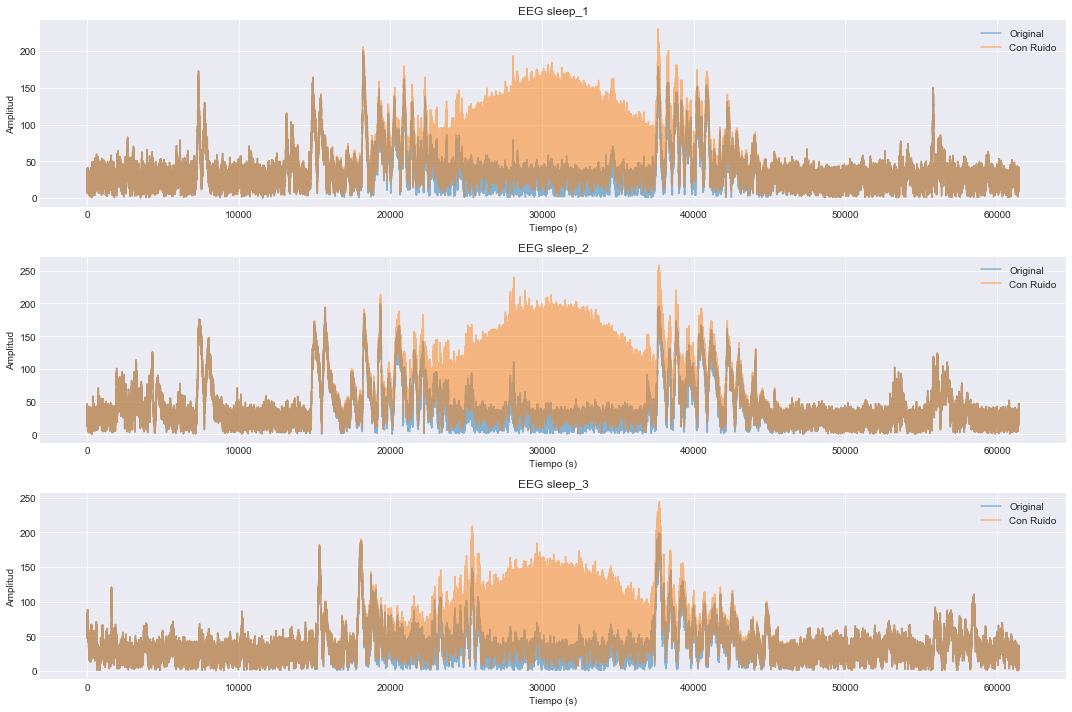

In [5]:
# Definimos las características del pulso gaussiano
fs = 1024.0  # Frecuencia de muestreo
t = np.arange(0, 60, 1/fs)  # Tiempo de 0 a 60 segundos
f_carrier = 500  # Frecuencia portadora
center = 30  # Centro del pulso
sigma = 5  # Desviación estándar

# Generamos el pulso gaussiano y se lo sumamos a la señal EEG
eeg_files_gaussian: Dict[str, np.ndarray] = {}
for key in channel_names:
    # Definimos la amplitud del pulso
    amp = eeg_data[key].std() * 5
    # Generamos el pulso gaussiano
    pulse = gaussian_pulse(fs, t, f_carrier, amp, center, sigma)
    # Lo sumamos a la señal EEG
    eeg_files_gaussian[key] = eeg_data[key] + np.abs(pulse)

# Guardamos los datos con ruido en archivos .txt
eeg_gaussian_folder: Path = notebook_folder / \
    "eeg_files_noise" / "eeg_files_gaussian_single_hard"
# Crea la carpeta si no existe
eeg_gaussian_folder.mkdir(exist_ok=True, parents=True)
for key in channel_names:
    np.savetxt(eeg_gaussian_folder /
               f"input_nonepi_{key}.txt", eeg_files_gaussian[key], fmt="%.6f")

# Finalmente graficamos los datos con ruido sobre los originales
plt.style.use("seaborn-darkgrid")
plt.figure(figsize=(15, 10))
for i, key in enumerate(channel_names):
    plt.subplot(len(channel_names), 1, i + 1)
    plt.plot(eeg_data[key], label="Original", alpha=0.5)
    plt.plot(eeg_files_gaussian[key], label="Con Ruido", alpha=0.5)
    plt.title(f"EEG {key}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.tight_layout()

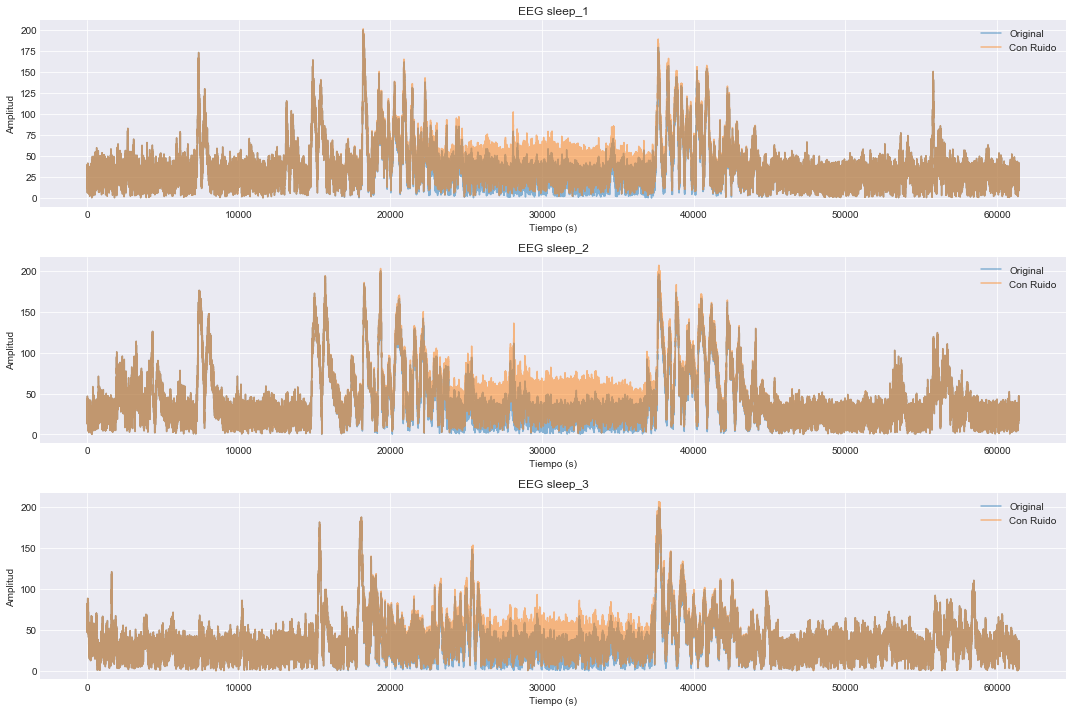

In [6]:
# Definimos las características del pulso gaussiano
fs = 1024.0  # Frecuencia de muestreo
t = np.arange(0, 60, 1/fs)  # Tiempo de 0 a 60 segundos
f_carrier = 500  # Frecuencia portadora
center = 30  # Centro del pulso
sigma = 5  # Desviación estándar

# Generamos el pulso gaussiano y se lo sumamos a la señal EEG
eeg_files_gaussian: Dict[str, np.ndarray] = {}
for key in channel_names:
    # Definimos la amplitud del pulso
    amp = eeg_data[key].std()
    # Generamos el pulso gaussiano
    pulse = gaussian_pulse(fs, t, f_carrier, amp, center, sigma)
    # Lo sumamos a la señal EEG
    eeg_files_gaussian[key] = eeg_data[key] + np.abs(pulse)

# Guardamos los datos con ruido en archivos .txt
eeg_gaussian_folder: Path = notebook_folder / \
    "eeg_files_noise" / "eeg_files_gaussian_single_soft"
# Crea la carpeta si no existe
eeg_gaussian_folder.mkdir(exist_ok=True, parents=True)
for key in channel_names:
    np.savetxt(eeg_gaussian_folder /
               f"input_nonepi_{key}.txt", eeg_files_gaussian[key], fmt="%.6f")

# Finalmente graficamos los datos con ruido sobre los originales
plt.style.use("seaborn-darkgrid")
plt.figure(figsize=(15, 10))
for i, key in enumerate(channel_names):
    plt.subplot(len(channel_names), 1, i + 1)
    plt.plot(eeg_data[key], label="Original", alpha=0.5)
    plt.plot(eeg_files_gaussian[key], label="Con Ruido", alpha=0.5)
    plt.title(f"EEG {key}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.tight_layout()

### Múltiples pulsos gaussianos


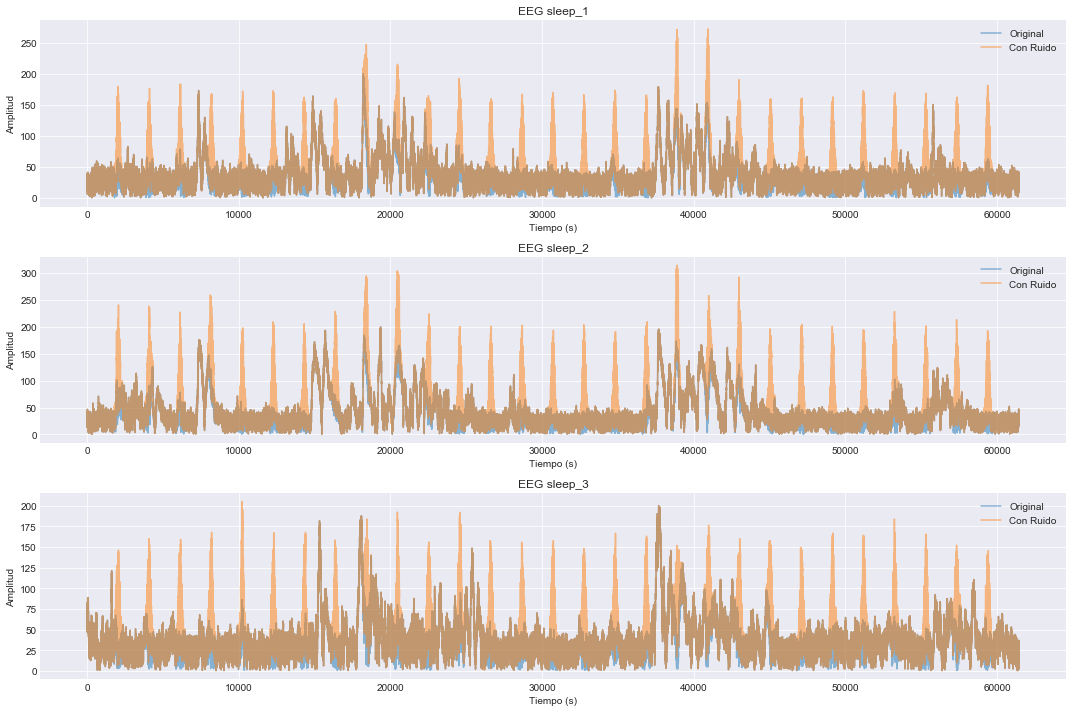

In [7]:
# Definimos las características del pulso gaussiano
fs = 1024.0  # Frecuencia de muestreo
t = np.arange(0, 60, 1/fs)  # Tiempo de 0 a 60 segundos
f_carrier = 500  # Frecuencia portadora
centers = np.arange(2, 60, 2)  # Centros del pulso gaussiano
sigmas = np.ones(len(centers)) * .1  # Desviación estándar

# Generamos el pulso gaussiano y se lo sumamos a la señal EEG
eeg_files_gaussian: Dict[str, np.ndarray] = {}
for key in channel_names:
    # Definimos la amplitud del pulso
    amp = eeg_data[key].std() * 5
    # Generamos el pulso gaussiano
    pulse = multiple_guassian_pulses(fs, t, f_carrier, amp, centers, sigmas)
    # Lo sumamos a la señal EEG
    eeg_files_gaussian[key] = eeg_data[key] + np.abs(pulse)

# Guardamos los datos con ruido en archivos .txt
eeg_gaussian_folder: Path = notebook_folder / \
    "eeg_files_noise" / "eeg_files_gaussian_multiple_hard"
# Crea la carpeta si no existe
eeg_gaussian_folder.mkdir(exist_ok=True, parents=True)
for key in channel_names:
    np.savetxt(eeg_gaussian_folder /
               f"input_nonepi_{key}.txt", eeg_files_gaussian[key], fmt="%.6f")

# Finalmente graficamos los datos con ruido sobre los originales
plt.style.use("seaborn-darkgrid")
plt.figure(figsize=(15, 10))
for i, key in enumerate(channel_names):
    plt.subplot(len(channel_names), 1, i + 1)
    plt.plot(eeg_data[key], label="Original", alpha=0.5)
    plt.plot(eeg_files_gaussian[key], label="Con Ruido", alpha=0.5)
    plt.title(f"EEG {key}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.tight_layout()

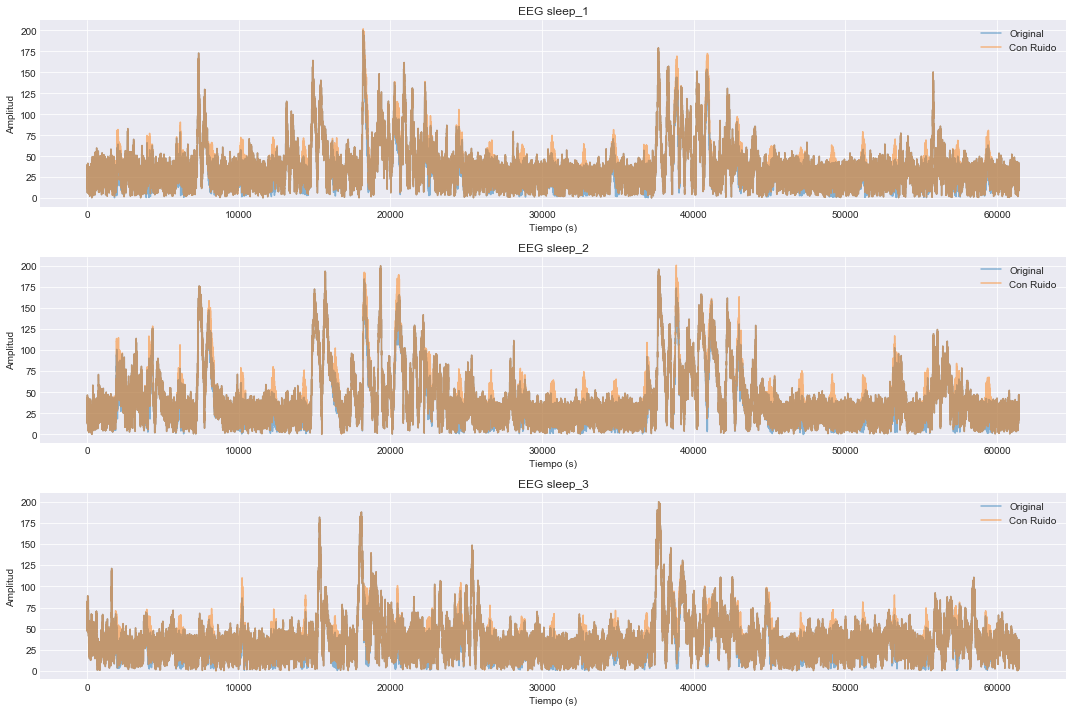

In [8]:
# Definimos las características del pulso gaussiano
fs = 1024.0  # Frecuencia de muestreo
t = np.arange(0, 60, 1/fs)  # Tiempo de 0 a 60 segundos
f_carrier = 500  # Frecuencia portadora
centers = np.arange(2, 60, 2)  # Centros del pulso gaussiano
sigmas = np.ones(len(centers)) * .1  # Desviación estándar

# Generamos el pulso gaussiano y se lo sumamos a la señal EEG
eeg_files_gaussian: Dict[str, np.ndarray] = {}
for key in channel_names:
    # Definimos la amplitud del pulso
    amp = eeg_data[key].std()
    # Generamos el pulso gaussiano
    pulse = multiple_guassian_pulses(fs, t, f_carrier, amp, centers, sigmas)
    # Lo sumamos a la señal EEG
    eeg_files_gaussian[key] = eeg_data[key] + np.abs(pulse)

# Guardamos los datos con ruido en archivos .txt
eeg_gaussian_folder: Path = notebook_folder / \
    "eeg_files_noise" / "eeg_files_gaussian_multiple_soft"
# Crea la carpeta si no existe
eeg_gaussian_folder.mkdir(exist_ok=True, parents=True)
for key in channel_names:
    np.savetxt(eeg_gaussian_folder /
               f"input_nonepi_{key}.txt", eeg_files_gaussian[key], fmt="%.6f")

# Finalmente graficamos los datos con ruido sobre los originales
plt.style.use("seaborn-darkgrid")
plt.figure(figsize=(15, 10))
for i, key in enumerate(channel_names):
    plt.subplot(len(channel_names), 1, i + 1)
    plt.plot(eeg_data[key], label="Original", alpha=0.5)
    plt.plot(eeg_files_gaussian[key], label="Con Ruido", alpha=0.5)
    plt.title(f"EEG {key}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.tight_layout()

## Ataques Flooding y Jamming


Realizamos primero el ataque Flooding.


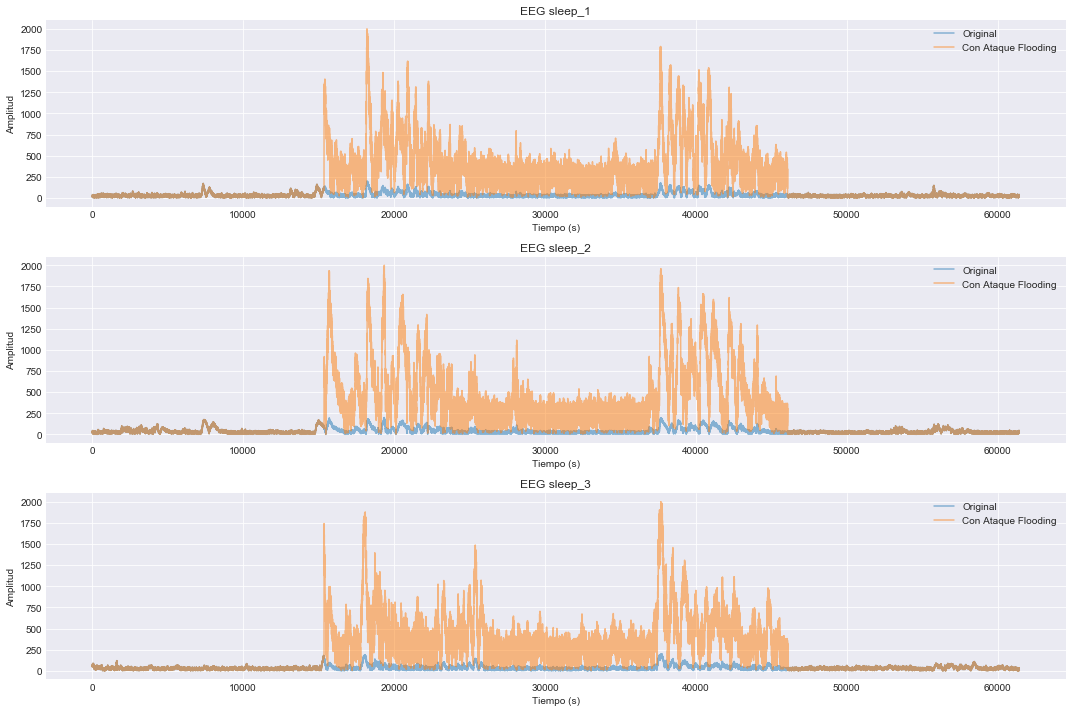

In [9]:
# Definomos las características del ataque Flooding
t = np.arange(0, 60, 1/fs)  # Tiempo de 0 a 60 segundos
factor = 10  # Factor de aumento de la amplitud
t_attack = (15, 45)  # Intervalo de tiempo del ataque


# Realizamos el ataque Flooding a la señal EEG
eeg_files_flooding: Dict[str, np.ndarray] = {}
for key in channel_names:
    # Realizamos el ataque Flooding
    flooding = flooding_jamming_attack(eeg_data[key], t, factor, t_attack)
    # Guardamos la señal con el ataque
    eeg_files_flooding[key] = flooding

# Guardamos los datos con el ataque en archivos .txt
eeg_flooding_folder: Path = notebook_folder / \
    "eeg_files_noise" / "eeg_files_flooding_limited"
# Crea la carpeta si no existe
eeg_flooding_folder.mkdir(exist_ok=True, parents=True)
for key in channel_names:
    np.savetxt(eeg_flooding_folder /
               f"input_nonepi_{key}.txt", eeg_files_flooding[key], fmt="%.6f")

# Finalmente graficamos los datos con el ataque sobre los originales
plt.style.use("seaborn-darkgrid")
plt.figure(figsize=(15, 10))
for i, key in enumerate(channel_names):
    plt.subplot(len(channel_names), 1, i + 1)
    plt.plot(eeg_data[key], label="Original", alpha=0.5)
    plt.plot(eeg_files_flooding[key], label="Con Ataque Flooding", alpha=0.5)
    plt.title(f"EEG {key}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.tight_layout()
# Mostramos las gráficas
plt.show()

Ahora realizamos el ataque Jamming.


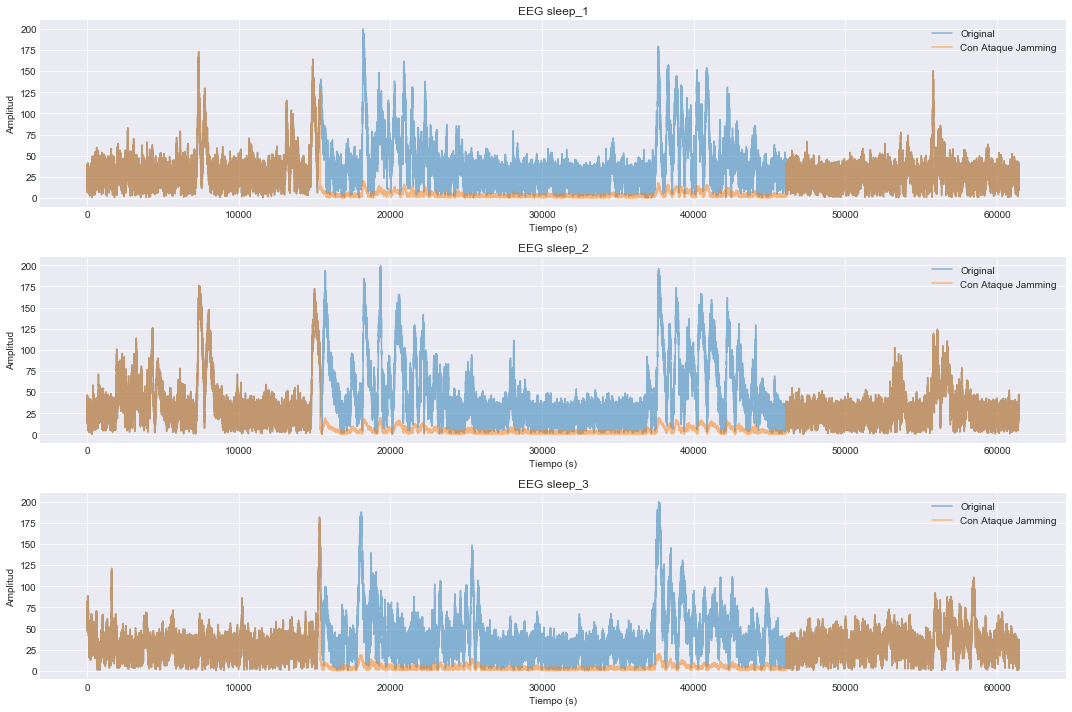

In [10]:
# Definimos las características del ataque Jamming
t = np.arange(0, 60, 1/fs)  # Tiempo de 0 a 60 segundos
factor = 0.1  # Factor de aumento de la amplitud
t_attack = (15, 45)  # Intervalo de tiempo del ataque

# Realizamos el ataque Jamming a la señal EEG
eeg_files_jamming: Dict[str, np.ndarray] = {}
for key in channel_names:
    # Realizamos el ataque Jamming
    jamming = flooding_jamming_attack(eeg_data[key], t, factor, t_attack)
    # Guardamos la señal con el ataque
    eeg_files_jamming[key] = jamming

# Guardamos los datos con el ataque en archivos .txt
eeg_jamming_folder: Path = notebook_folder / \
    "eeg_files_noise" / "eeg_files_jamming_limited"
# Crea la carpeta si no existe
eeg_jamming_folder.mkdir(exist_ok=True, parents=True)
for key in channel_names:
    np.savetxt(eeg_jamming_folder /
               f"input_nonepi_{key}.txt", eeg_files_jamming[key], fmt="%.6f")

# Finalmente graficamos los datos con el ataque sobre los originales
plt.style.use("seaborn-darkgrid")
plt.figure(figsize=(15, 10))
for i, key in enumerate(channel_names):
    plt.subplot(len(channel_names), 1, i + 1)
    plt.plot(eeg_data[key], label="Original", alpha=0.5)
    plt.plot(eeg_files_jamming[key], label="Con Ataque Jamming", alpha=0.5)
    plt.title(f"EEG {key}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.tight_layout()
# Mostramos las gráficas
plt.show()

## Ataque "Scanning"


Aplicamos un "scanning" que aimplifique la señal.


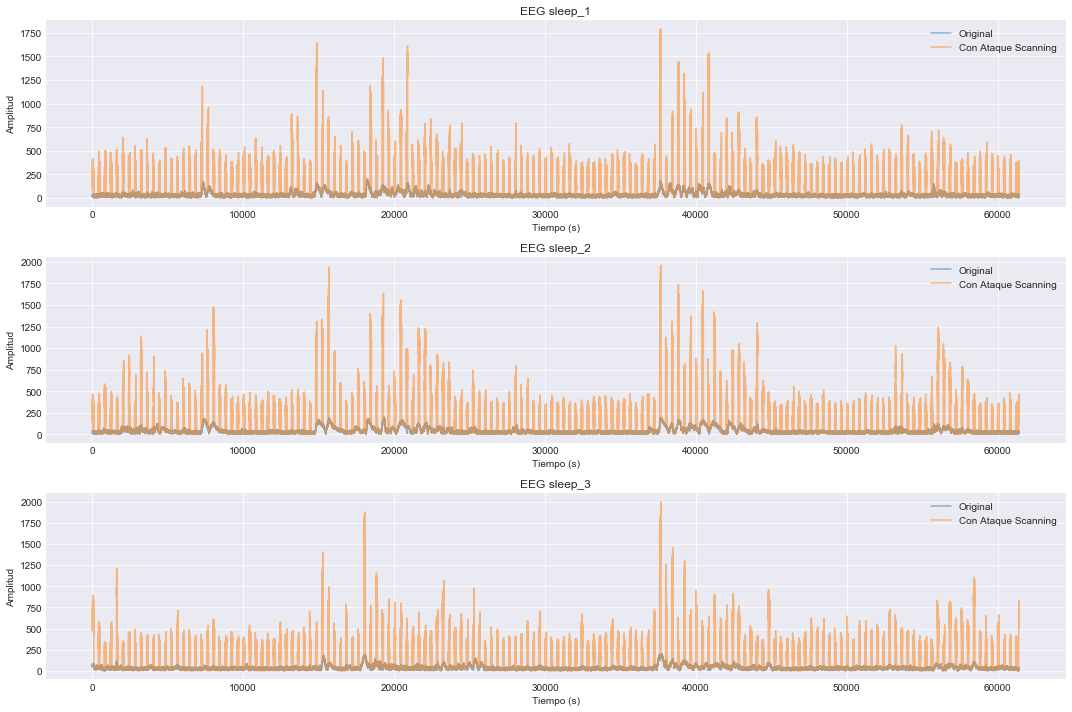

In [11]:
# Definimos las características del ataque Scanning
fs = 1024.0  # Frecuencia de muestreo
t = np.arange(0, 60, 1/fs)  # Tiempo de 0 a 60 segundos
factor = 10  # Factor de aumento de la amplitud
t_attack = (0, 60)  # Intervalo de tiempo del ataque
dt = 1/fs * 100
gap = 4

# Realizamos el ataque Scanning a la señal EEG
eeg_files_scanning: Dict[str, np.ndarray] = {}
for key in channel_names:
    # Realizamos el ataque Scanning
    scanning = scanning_attack(eeg_data[key], fs, t, t_attack, dt, gap, factor)
    # Guardamos la señal con el ataque
    eeg_files_scanning[key] = scanning

# Guardamos los datos con el ataque en archivos .txt
eeg_scanning_folder: Path = notebook_folder / \
    "eeg_files_noise" / "eeg_files_scanning_higher"
# Crea la carpeta si no existe
eeg_scanning_folder.mkdir(exist_ok=True, parents=True)
for key in channel_names:
    np.savetxt(eeg_scanning_folder /
               f"input_nonepi_{key}.txt", eeg_files_scanning[key], fmt="%.6f")

# Finalmente graficamos los datos con el ataque sobre los originales
plt.style.use("seaborn-darkgrid")
plt.figure(figsize=(15, 10))
for i, key in enumerate(channel_names):
    plt.subplot(len(channel_names), 1, i + 1)
    plt.plot(eeg_data[key], label="Original", alpha=0.5)
    plt.plot(eeg_files_scanning[key], label="Con Ataque Scanning", alpha=0.5)
    plt.title(f"EEG {key}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.tight_layout()
# Mostramos las gráficas
plt.show()

Aplicamos un "scanning" que reduzca la señal.


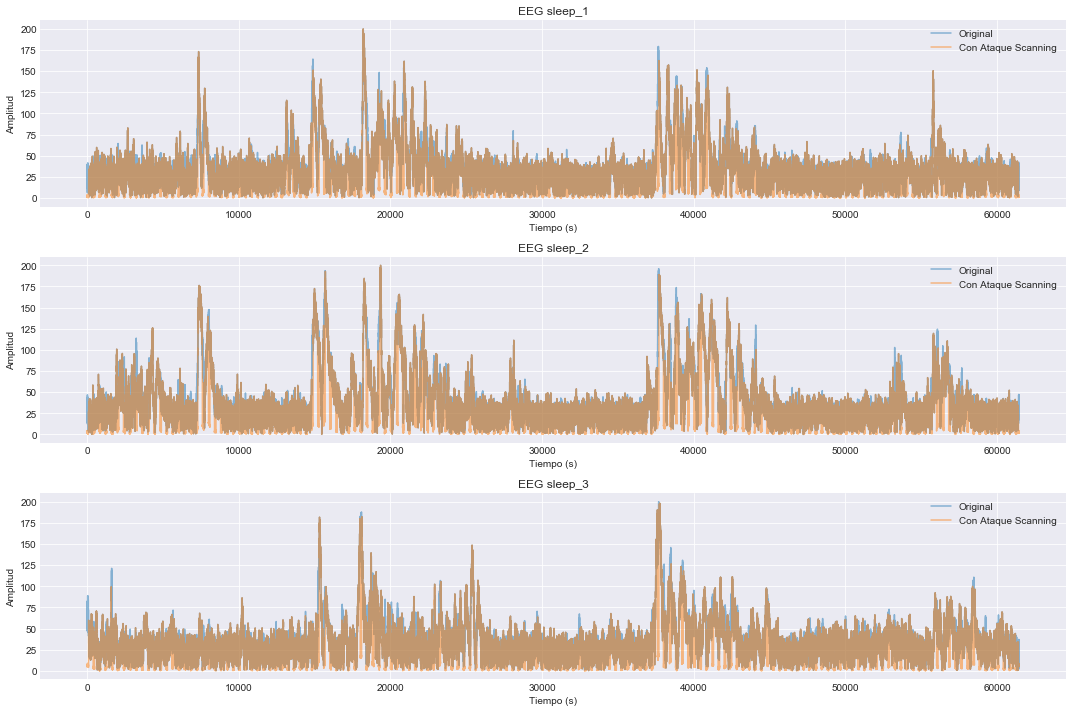

In [12]:
# Definimos las características del ataque Scanning
fs = 1024.0  # Frecuencia de muestreo
t = np.arange(0, 60, 1/fs)  # Tiempo de 0 a 60 segundos
factor = 0.1  # Factor de aumento de la amplitud
t_attack = (0, 60)  # Intervalo de tiempo del ataque
dt = 1/fs * 100
gap = 4

# Realizamos el ataque Scanning a la señal EEG
eeg_files_scanning: Dict[str, np.ndarray] = {}
for key in channel_names:
    # Realizamos el ataque Scanning
    scanning = scanning_attack(eeg_data[key], fs, t, t_attack, dt, gap, factor)
    # Guardamos la señal con el ataque
    eeg_files_scanning[key] = scanning

# Guardamos los datos con el ataque en archivos .txt
eeg_scanning_folder: Path = notebook_folder / \
    "eeg_files_noise" / "eeg_files_scanning_lower"
# Crea la carpeta si no existe
eeg_scanning_folder.mkdir(exist_ok=True, parents=True)
for key in channel_names:
    np.savetxt(eeg_scanning_folder /
               f"input_nonepi_{key}.txt", eeg_files_scanning[key], fmt="%.6f")

# Finalmente graficamos los datos con el ataque sobre los originales
plt.style.use("seaborn-darkgrid")
plt.figure(figsize=(15, 10))
for i, key in enumerate(channel_names):
    plt.subplot(len(channel_names), 1, i + 1)
    plt.plot(eeg_data[key], label="Original", alpha=0.5)
    plt.plot(eeg_files_scanning[key], label="Con Ataque Scanning", alpha=0.5)
    plt.title(f"EEG {key}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.tight_layout()
# Mostramos las gráficas
plt.show()

## Ataque Nonce


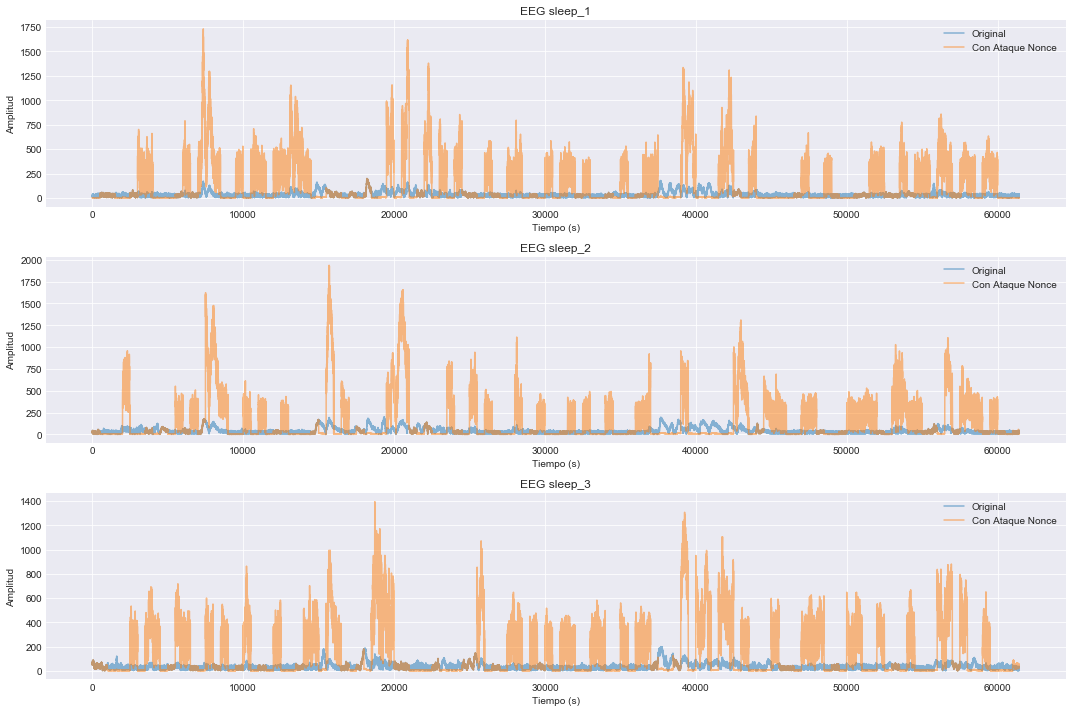

In [15]:
# Definimos las características del ataque Nonce
fs = 1024.0  # Frecuencia de muestreo
t = np.arange(0, 60, 1/fs)  # Tiempo de 0 a 60 segundos
probs = (0.4, 0.2, 0.4)  # Probabilidades de cada ataque
powers = (10.0, 1.0, 0.1)  # Potencias de cada ataque
t_attack = (0, 60)
dt = 1/fs * 500

# Realizamos el ataque Nonce a los datos EEG
eeg_files_nonce: Dict[str, np.ndarray] = {}
for key in channel_names:
    # Realizamos el ataque Nonce
    nonce = nonce_attack(eeg_data[key], fs, t, dt, t_attack, probs, powers)
    # Sustituimos los archivos originales por los atacados
    eeg_files_nonce[key] = nonce

# Guardamos los datos con ataque Nonce en archivos .txt
eeg_nonce_folder: Path = notebook_folder / \
    "eeg_files_noise" / "eeg_files_nonce_2"
# Crea la carpeta si no existe
eeg_nonce_folder.mkdir(exist_ok=True, parents=True)
for key in channel_names:
    np.savetxt(eeg_nonce_folder /
               f"input_nonepi_{key}.txt", eeg_files_nonce[key], fmt="%.6f")

# Finalmente graficamos los datos con ataque Nonce sobre los originales
plt.style.use("seaborn-darkgrid")
plt.figure(figsize=(15, 10))
for i, key in enumerate(channel_names):
    plt.subplot(len(channel_names), 1, i + 1)
    plt.plot(eeg_data[key], label="Original", alpha=0.5)
    plt.plot(eeg_files_nonce[key], label="Con Ataque Nonce", alpha=0.5)
    plt.title(f"EEG {key}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.tight_layout()
# Mostramos las gráficas
plt.show()